In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data preparation and EDA

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'
!wget $data 
df = pd.read_csv('data.csv')

--2025-10-07 11:41:58--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.008s  

2025-10-07 11:41:58 (169 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df['make'].str.lower().str.replace(' ', '_')

strings = list(df.dtypes[df.dtypes == 'object'].index)
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_')

<Axes: xlabel='msrp', ylabel='Count'>

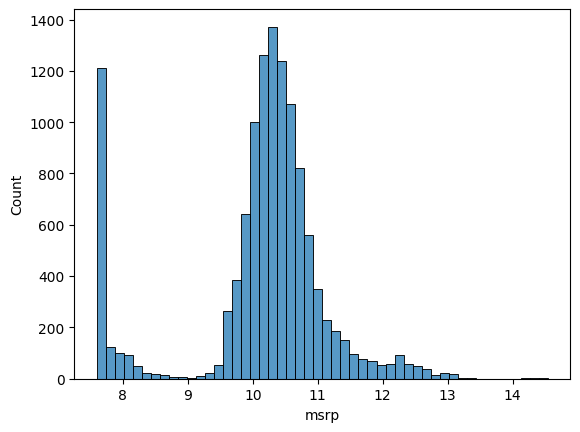

In [5]:
#sns.histplot(df.msrp, bins=50)

# log1p adds 1 to all the values, to avoid log 0
price_logs = np.log1p(df.msrp)
sns.histplot(price_logs, bins=50)

In [6]:
df.isnull().sum()


make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

## Split into train, validation, test set

# Use 60/20/20
n = len(df)

# Calculate how many total observations for the split
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

# Shuffle the index
idx = np.arange(n)
np.random.seed(2)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

# Reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
# Note the log1p
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [15]:
# Delete the target variables from feature df
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

## Linear regression model

$$
g(x_i) = w_0 + x_{i1} \cdot w_1 + x_{i2} \cdot w_2 + \dots + x_{in} \cdot w_n
$$

A model to predict $g(x_i)$ value where $w$ is weight. $w_0$ is the bias term when there is no information. All other features $x$ are multiplied by their corresponding weights $w$. The model can be summarized as below: $$
g(x_i) = w_0 + \sum_{j=1}^{n} w_j \cdot x_{ij}
$$

From the summarised model, we can see that this part $\sum_{j=1}^{n} w_j \cdot x_{ij}$ is a vector-vector multiplication or dot product which can further be simplied into: $$
g(x_i) = w_0 + \mathbf{x}_i^\top \mathbf{w}
$$

This is the implementation of the model:

In [16]:
w0 = 7.1
def linear_regression(xi):
    
    n = len(xi)
    
    pred = w0
    w = [0.01, 0.04, 0.002]
    for j in range(n):
        pred = pred + w[j] * xi[j]
    return pred

In [17]:
# Example
df_train.iloc[10]

make                                 rolls-royce
model                     phantom_drophead_coupe
year                                        2015
engine_fuel_type     premium_unleaded_(required)
engine_hp                                  453.0
engine_cylinders                            12.0
transmission_type                      automatic
driven_wheels                   rear_wheel_drive
number_of_doors                              2.0
market_category        exotic,luxury,performance
vehicle_size                               large
vehicle_style                        convertible
highway_mpg                                   19
city_mpg                                      11
popularity                                    86
Name: 10, dtype: object

In [18]:
xi = [453, 11, 86]
w0 = 7.17
w = [0.01, 0.04, 0.002]

linear_regression(xi)

12.312

In [20]:
np.set_printoptions(legacy='1.25')

In [21]:
np.expm1(12.312)

222347.2221101062

Training the model is done using train set to estimate the weights.

## Train linear regression model

$w$ can be approximated by: $$
\mathbf{w} = (X^\top X)^{-1} X^\top y
$$

In [25]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X]) # Add bias term w_0 that is the baseline price of a car with no other information

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [26]:
X = [
    [148, 24, 1385],
    [132, 25, 2031],
    [453, 11, 86],
    [158, 24, 185],
    [172, 25, 201],
    [413, 11, 86],
    [38,  54, 185],
    [142, 25, 431],
    [453, 31, 86],
]

X = np.array(X)
y = [10000, 20000, 15000, 20050, 10000, 20000, 15000, 25000, 12000]

train_linear_regression(X, y)

(25844.754055766753, array([ -16.08906468, -199.47254894,   -1.22802883]))

The weights results can be read as the baseline car price, then each additional feature, can cause an increase/decrease in price by the respective feature weight.

Now, creating a baseline model using numerical features from the train dataset:

In [27]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg',
        'city_mpg', 'popularity']

X_train = df_train[base].fillna(0).values

w0, w = train_linear_regression(X_train, y_train) # Note that we are training to get the weights

y_pred = w0 + X_train.dot(w) # Then we use the weights to predict y using simplified LR

In [28]:
w0, w, y_pred

(7.927257388069986,
 array([ 9.70589522e-03, -1.59103494e-01,  1.43792133e-02,  1.49441072e-02,
        -9.06908672e-06]),
 array([ 9.54792783,  9.38733977,  9.67197758, ..., 10.30423015,
        11.9778914 ,  9.99863111]))

## Evaluate using RMSE

In [29]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [30]:
rmse(y_train, y_pred)

0.7554192603920132

## Validate the model

In [31]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [32]:
# Use training data to approximate weights
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

# Use those weights to validate
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

# Evaluate
rmse(y_val, y_pred)

0.761653099130156

## Dealing with categorical variable

In [35]:
categorical_columns = [
    'make', 'model', 'engine_fuel_type', 'driven_wheels', 'market_category',
    'vehicle_size', 'vehicle_style']

categorical = {}

for c in categorical_columns:
    categorical[c] = list(df_train[c].value_counts().head().index)

In [36]:
def prepare_X(df):
    df = df.copy()
    
    df['age'] = 2017 - df['year']
    features = base + ['age']

    for v in [2, 3, 4]:
        df['num_doors_%d' % v] = (df.number_of_doors == v).astype(int)
        features.append('num_doors_%d' % v)

    for name, values in categorical.items():
        for value in values:
            df['%s_%s' % (name, value)] = (df[name] == value).astype(int)
            features.append('%s_%s' % (name, value))

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

In [37]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

53.70370772576197

## Regularization

When there are duplicate columns on the feature matrix, we can add small number on the diagonal so that weights can be calculated appropriately. This is called regularization

In [38]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0]) # see here we add r

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [39]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.4608208286551885

Next, we can tune the hyperparamter in the model. In this case we are tuning for r:

In [40]:
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score)

0.0 120883643437600.25 53.70370772576197
1e-05 8.377536683531915 0.46081532306190714
0.0001 7.139523156766516 0.4608153655817384
0.001 7.1309028247366735 0.46081585855400226
0.1 7.000232409563555 0.4608736549095069
1 6.25074784766319 0.46158128382736374
10 4.729512585705947 0.4726098772668833


In [41]:
r = 0.001
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=r)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
score = rmse(y_val, y_pred)
score

0.46081585855400226

## Use the model on test dataset

In [42]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
X_full_train = prepare_X(df_full_train)

y_full_train = np.concatenate([y_train, y_val])

In [43]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [44]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

0.4600753970082232

In [45]:
# Real example test
car = df_test.iloc[20].to_dict()
car

{'make': 'toyota',
 'model': 'sienna',
 'year': 2015,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 266.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'automatic',
 'driven_wheels': 'front_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': nan,
 'vehicle_size': 'large',
 'vehicle_style': 'passenger_minivan',
 'highway_mpg': 25,
 'city_mpg': 18,
 'popularity': 2031}

In [46]:
df_small = pd.DataFrame([car])

X_small = prepare_X(df_small)

y_pred = w0 + X_small.dot(w)
y_pred = y_pred[0]
y_pred

10.63249251496894

In [47]:
np.expm1(y_pred)

41459.337028846196

In [48]:
np.expm1(y_test[20])

35000.00000000001